# Single Shot Multibox Detector Implementation

In [1]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
directory = "input/detection-dataset/insect/insect-details/annotations"
image_directory = "input/detection-dataset/insect/insect-details/all_images"
validate_directory = "input/detection-dataset/insect/insect-details/validations"
df = pd.read_csv("newData.csv")
df_test = pd.read_csv("input/detection-dataset/submission.csv")

SSD is Single Shot Multibox Detector. It is a technique that is used to detect objects in images using a single deep neural network. Basically its used for object detection in an image. By using a base architecture of VGG-16 Architecture, SSD is able to out perform other object detectors like YOLO and Faster R-CNN in both speed and accuracy. The architecture of SSD is given in the figure below. Training a SSD model from scratch will require a lot of data, so here I have imported pretrained weights (Caffe Face Detector Model) using OpenCV.

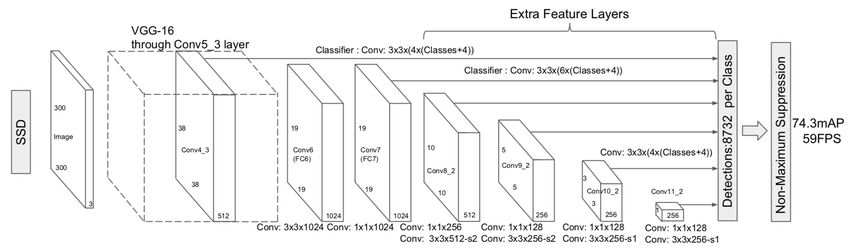

In [2]:
cvNet = cv2.dnn.readNetFromCaffe('input/caffe-model/architecture.txt','input/caffe-model/weights.caffemodel')

## Functions
1. JSON Function fetches the json file that has the data of bounding box in the training dataset.

2. Gamma correction, or often simply gamma, is a nonlinear operation used to encode and decode luminance or tristimulus values in video or still image systems. 

3. In simple terms it is used to instill some light in the image. If gamma < 1, image will shift towards darker end of the spectrum and when gamma > 1, there will be more light in the image.

In [3]:
def getJSON(filePathandName):
    with open(filePathandName,'r') as f:
        return json.load(f)

In [4]:
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

## Data Preprocessing

Lets look at the JSON data given for training:

- The Annotations field contains the data of all the faces present in a particular image.
- There are various classnames but the true classnames are **Licinus** and **Trechus** .

In [5]:
jsonfiles= []
for i in os.listdir(directory):
    jsonfiles.append(getJSON(os.path.join(directory,i)))
jsonfiles[0]

{'FileName': 'Licinus19_0_1039_1.jpg',
 'NumOfAnno': 1,
 'Annotations': [{'isProtected': False,
   'ID': 20,
   'BoundingBox': [125.76506024096386,
    251.66566265060243,
    251.53012048192772,
    503.33132530120486],
   'classname': 'Licinus',
   'Confidence': 1,
   'Attributes': {}}]}

In [6]:
df = pd.read_csv("newData.csv")
df.head()

,name,x1,x2,y1,y2,classname
0,Licinus19_0_1039_1.jpg,125.765060,251.665663,251.530121,503.331325,Licinus
1,Licinus19_0_1048_11.jpg,136.755319,296.460993,273.510638,588.000000,Licinus
2,Licinus19_0_1057_21.jpg,168.379397,211.635678,327.241206,417.000000,Licinus
3,Licinus19_0_1066_31.jpg,150.598726,259.515924,285.000000,514.000000,Licinus
4,Licinus19_0_1069_41.jpg,146.010638,270.960993,263.000000,503.000000,Licinus


- By using the **Licinus** label and **Trechus** label, the bounding box data from json files is extracted.
- The faces from any particular image are extracted and stored in the data list along with its label for the training process.

In [7]:
data = []
img_size = 124
Licinus = ['Licinus']
Trechus = ["Trechus"]
labels={'Licinus':0,'Trechus':1}
for i in df["name"].unique():
    f = i+".json"
    for j in getJSON(os.path.join(directory,f)).get("Annotations"):
        if j["classname"] in Licinus:
            a = j["BoundingBox"]
            x,y,w,h = [round(x) for x in a]
            img = cv2.imread(image_directory+'/'+i,1)
            img = img[y:h,x:w]
            #img = cv2.resize(img,(img_size,img_size))
            data.append([img,labels["Licinus"]])
random.shuffle(data)      

In [8]:
len(data)

132

The visualization below tells us that the Number of each class image which is used to check it is an imbalanced dataset or not. But since we are using a SSD pretrained model for research based, which is trained to detect each insect specifics, therefore this imbalance would not matter a lot

In [9]:
p = []
for face in data:
    if(face[1] == 0):
        p.append("Licinus")
    else:
        p.append("Trechus")

print(p)
#sns.countplot(p)

['Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus', 'Licinus'

In [10]:
X = []
Y = []
for features,label in data:
    X.append(features)
    Y.append(label)

In [11]:
X[0].shape

(232, 117, 3)

In [13]:
X = np.array(X)/255.0
X = X.reshape(-1,124,124,3)
Y = np.array(Y)

ValueError: cannot reshape array of size 132 into shape (124,124,3)

In [ ]:
np.unique(Y)

In [ ]:
Y.shape

## Model Architecture and Training Process

In [14]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(124,124,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Output shape = ([input volume - kernel size + 2 * padding / stride] + 1)

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 64)      18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 120, 120, 128)     73856     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 60, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 460800)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 460800)            0

In [16]:
from tensorflow.keras.optimizers import SGD
opt = SGD(learning_rate=0.01)
model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics=['accuracy'])

In [17]:
xtrain,xval,ytrain,yval=train_test_split(X, Y,train_size=0.6667,random_state=0)

In [18]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,    
        rotation_range=15,    
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=False)
datagen.fit(xtrain)

ValueError: setting an array element with a sequence.

In [23]:
history = model.fit(datagen.flow(xtrain, ytrain, batch_size=2),
                    steps_per_epoch=xtrain.shape[0]//2,
                    epochs=26,
                    verbose=1,
                    validation_data=(xval, yval))

#Dataset must equal (steps_per_epoch * epochs)

ValueError: setting an array element with a sequence.

In [20]:
plt.plot(history.history['accuracy'],'g')
plt.plot(history.history['val_accuracy'],'b')
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

In [21]:
plt.plot(history.history['loss'],'g')
plt.plot(history.history['val_loss'],'b')
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

## Model Testing

The test dataset has a few images and to evaluate the model I have taken a handful of images from this dataset as there are no labels for faces in the dataset.

In [22]:
print(len(df_test["name"]),len(df_test["name"].unique()))

20 20


In [45]:
test_images = ['Licinus10_0_9287.jpg','testing2.jpg','validate05.jpg','Trechus02.jpg']

Gamma Correction for making the image appear in more light.**(Gamma = 2)**
blobFromImage creates 4-dimensional blob from image. Optionally resizes and crops image from center, subtract mean values, scales values by scalefactor, swap Blue and Red channels. 

[Refer OpenCV documentation]
The blob is passed through the SSD network and detections are made with some confidence score.


Define a threshold confidence score, above which the detection will be considered as a candidate of being a face. (In this case **confidence threshold = 0.2**)
All the detections that qualify the confidence score are then passed to the architecture for classification into mask or non-mask image.

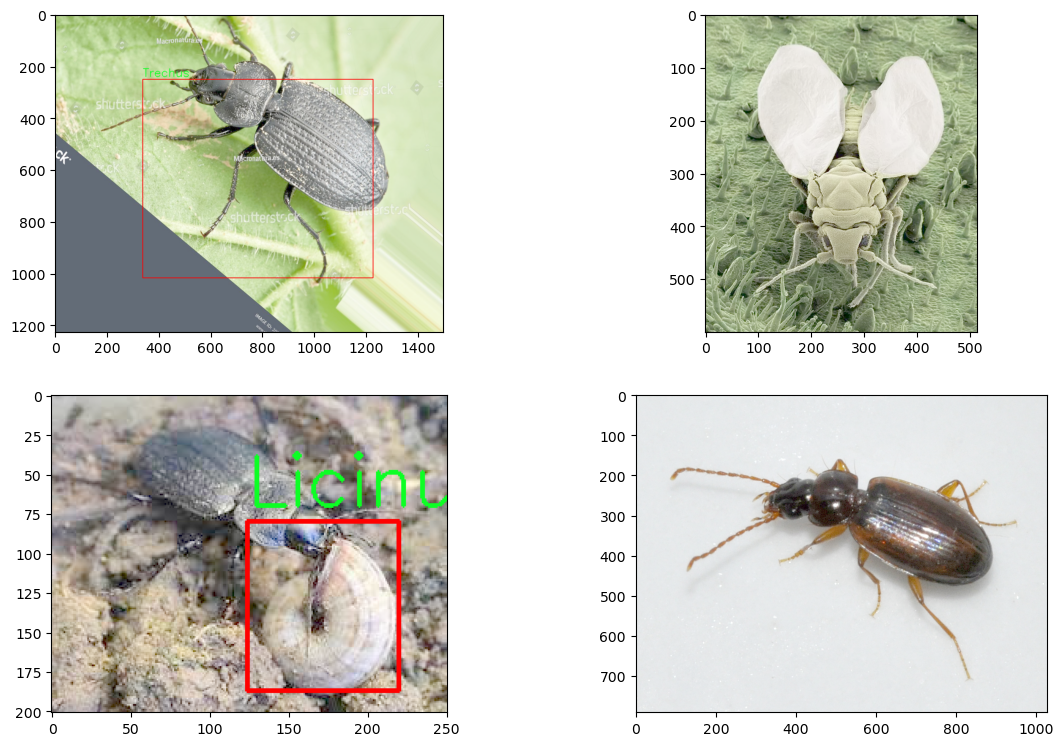

In [46]:
gamma = 2.0
fig = plt.figure(figsize = (14,14))
rows = 3
cols = 2
axes = []
assign = {'0':'Licinus','1':"Trechus"}
for j,im in enumerate(test_images):
    image =  cv2.imread(os.path.join(validate_directory,im),1)
    image =  adjust_gamma(image, gamma=gamma)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    cvNet.setInput(blob)
    detections = cvNet.forward()
    for i in range(0, detections.shape[2]):
        try:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX]
            confidence = detections[0, 0, i, 2]
            if confidence > 0.2:
                im = cv2.resize(frame,(img_size,img_size))
                im = np.array(im)/255.0
                im = im.reshape(1,124,124,3)
                result = model.predict(im)
                if result>0.5:
                    label_Y = 1
                else:
                    label_Y = 0
                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
                cv2.putText(image,assign[str(label_Y)] , (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (36,255,12), 2)
        
        except:pass
    axes.append(fig.add_subplot(rows, cols, j+1))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()